# Vectorize Raster Image
Single raster files - representing buildings, roads, water areas, ..., resp. - were exported from eCognition. With this script, we convert those raster files to vectors outside of eCognition as its vectorizing processes do not deliver satisfactory results.

In [19]:
import fiona
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import osr
import pandas as pd
import rasterio
import shapely

from osgeo import gdal, ogr
from rasterio.mask import mask
from rasterio.plot import show
from shapely.geometry import box, Polygon, MultiPolygon
from shapely import wkt

shapely.speedups.disable()

# 1) Create small subset of data

In [2]:
createsubset = 'yes'
#createsubset = 'no'

# 2) Define input and output

## 2.1) Input map features

In [3]:
featurename = "Buildings" # e.g. "Buildings", "PublicBuildings", Water"

## 2.2) Working directory

In [4]:
path = "data\\"

# file names
inputname = path + featurename + ".tif"
outputname = featurename + "_polygonized"

outputpath = path + outputname
rasterpath = r"02 Object extraction\\data\\""
inputraster = "Harvard Map Collection, Harvard College Library (n.d.) (Map 0).tif"

In [5]:
# create new directory
featurefolder = path + featurename
if not os.path.exists(featurefolder):
    os.makedirs(featurefolder)

# 3) Vectorization
## 3.1) *R2V*
Commercial raster to vector conversion tool (see Peller (2018); Brown (2002))
## 2.2) R tool *Map Vectorizer* 
See Arteaga (2013): Extraction of building outlines especially from cadastral/insurance maps<br>
## 2.3) ArcGIS*ArcScan* extension
Tracing of lines and recognition of basic geometric shapes
## 3.4) GDAL_Polygonize
See also Iosifescu, Tsorlini & Hurni (2016); Arteaga (2013)

In [6]:
# GDAL polygonize

sourceRaster = gdal.Open(inputname)
band = sourceRaster.GetRasterBand(1)
bandArray = band.ReadAsArray()

outShapefile = outputname

if not os.path.exists(featurefolder + "\\" + outputname + ".shp"):
    driver = ogr.GetDriverByName("ESRI Shapefile")
    if os.path.exists(outputpath + ".shp"):
        driver.DeleteDataSource(featurefolder + "\\" + outputname + ".shp")

    outDatasource = driver.CreateDataSource(featurefolder + "\\" + outputname + ".shp")

    # getting projection from source raster
    srs = osr.SpatialReference()
    srs.ImportFromWkt(sourceRaster.GetProjectionRef())

    outLayer = outDatasource.CreateLayer(featurefolder + "\\" + outputname + ".shp", srs)
    newField = ogr.FieldDefn('VALUE')
    outLayer.CreateField(newField)
    gdal.Polygonize( band, band, outLayer, -1, [], callback=None )
    outDatasource.Destroy()
    sourceRaster = None

else:
    print("Shapefile exists already.")

## 3.5) Create a subset
so that the input becomes a bit smaller and we only have to apply the following cells onto a smaller extent

In [7]:
# manually define corner coordinates
lat_point_list = [-465, -465, -207, -207]
lon_point_list = [412, 790, 790, 412]

## 3.6) Create vector dataset

In [8]:
if createsubset == 'yes':
    
    polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
    crs = {'init': 'epsg:4326'}
    subset_gdf = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])       

    shape_gdf = gpd.read_file(featurefolder + "\\" + outShapefile + ".shp")
    del shape_gdf['VALUE']

    # clip 
    clipped_series = gpd.clip(shape_gdf.buffer(0), subset_gdf) # buffer(0) is applied to eliminate invalid (self-intersecting) geometries in shape_gdf
    clipped = gpd.GeoDataFrame(geometry=gpd.GeoSeries(clipped_series), crs=crs)

    # drop linestrings
    for index, row in clipped.iterrows():
        if type(row.geometry) == shapely.geometry.polygon.Polygon:
            clipped.at[index, 'geometry'] = row.geometry

        if type(row.geometry) == shapely.geometry.collection.GeometryCollection:
            # get the polygon and only keep the polygon 
            for shape in row.geometry:
                if type(shape) == shapely.geometry.polygon.Polygon:
                    clipped.at[index, 'geometry'] = shape

    clipped = clipped[clipped.geom_type != 'MultiLineString']
    clipped = clipped[clipped.geom_type != 'LineString']
    clipped.crs = {'init' :'epsg:4326'}

C:\Users\schlegel\Anaconda3\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


In [9]:
# raster file
polygon_geom = Polygon(zip(lon_point_list, lat_point_list))

with rasterio.open(rasterpath + inputraster) as src:
    rgb_clipped, rgb_clipped_transform = rasterio.mask.mask(src, [polygon_geom], crop=True)
    out_meta = src.meta

out_meta.update({"driver": "GTiff",
                 "height": rgb_clipped.shape[1],
                 "width": rgb_clipped.shape[2],
                 "transform": rgb_clipped_transform})

## 3.7) Export

In [9]:
# create new directory
posteditingfolder = "\\post_editing"
if not os.path.exists(featurefolder + posteditingfolder):
    os.makedirs(featurefolder + posteditingfolder)

if createsubset == 'yes':
    shapefile = featurefolder + posteditingfolder + "\\" + featurename + "_polygonized_subset.shp"
    clipped.to_file(shapefile)
else:
    shapefile = featurefolder + "\\" + outputname + ".shp"

# 4) Vector Enhancement
e.g. smoothing, simplification, removal of small holes and single pixels<br>
## 4.1) QGIS *fix geometries*
due to self intersecting polygons<br>
<img src="figures/Lindley_polygonized.png" width="150" align="left"/>

In [10]:
# create temp directory
tempfolder = "/temp"
if not os.path.exists(featurefolder + posteditingfolder + tempfolder):
    os.makedirs(featurefolder + posteditingfolder + tempfolder)

In [11]:
# create bounding box

# get coordinates
c = fiona.open(shapefile)

b = box(c.bounds[0], c.bounds[1], c.bounds[2], c.bounds[3])
bb_coords = list(b.exterior.coords)

# create GeoDataFrame
bb = Polygon(bb_coords)
bb_gdf = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[bb])

if createsubset == 'yes':
    bb_gdf.to_file(featurefolder + posteditingfolder + tempfolder + "/subset_bb_gdf.shp")
else:
    bb_gdf.to_file(featurefolder + posteditingfolder + tempfolder + "/bb_gdf.shp")

In [12]:
# Get raster data and set working directory
for root, dir, files in os.walk(rasterpath):
    for file in files:
        if file.endswith(inputraster):
            raster = (os.path.join(root, file))
            
# export raster file
rgb = rasterio.open(raster, driver='GTiff') # RGB

Define the raster input and crop it to the extent of the vector file

In [16]:
if createsubset == 'yes':
    
    with fiona.open(featurefolder + posteditingfolder + tempfolder + "/subset_bb_gdf.shp", "r") as shp:
        shapes = [feature["geometry"] for feature in shp]

    out_image, out_transform = rasterio.mask.mask(rgb, shapes, crop=True)
    out_meta = rgb.meta

    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})
    
    with rasterio.open(featurefolder + posteditingfolder + tempfolder + "/subset_RGB_masked.tif", "w", **out_meta) as dest:
        dest.write(out_image)
        
else:
    
    with fiona.open(featurefolder + posteditingfolder + tempfolder + "/bb_gdf.shp", "r") as shp:
        shapes = [feature["geometry"] for feature in shp]

    out_image, out_transform = rasterio.mask.mask(rgb, shapes, crop=True)
    out_meta = rgb.meta

    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})
    
    with rasterio.open(featurefolder + posteditingfolder + tempfolder + "/RGB_masked.tif", "w", **out_meta) as dest:
        dest.write(out_image)   

In [17]:
# export
if createsubset == 'yes':
    rgb_cropped = rasterio.open(featurefolder + posteditingfolder + tempfolder + "/subset_RGB_masked.tif", driver='GTiff') # RGB
else:
    rgb_cropped = rasterio.open(featurefolder + posteditingfolder + tempfolder + "/RGB_masked.tif", driver='GTiff') # RGB

**Plot**

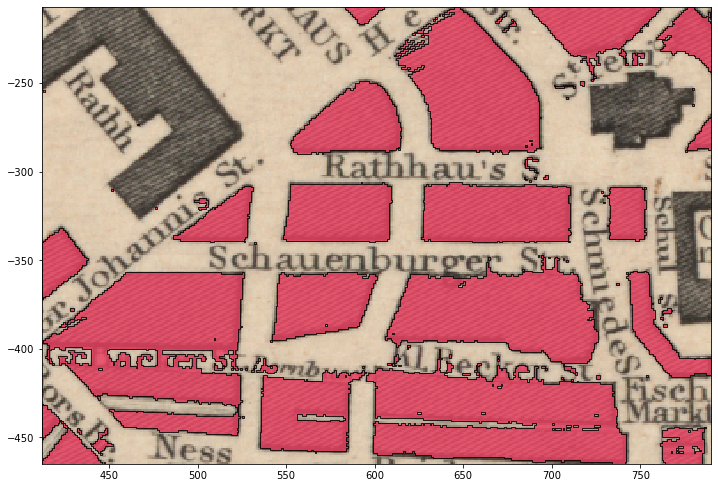

In [18]:
# open vector data
gdf = gpd.read_file(shapefile)

# plot vector on map
fig, ax = plt.subplots(figsize=(12, 10))
show(rgb_cropped.read(), transform=rgb_cropped.transform, ax=ax)
gdf.plot(ax=ax, color='#ec4062', edgecolor='black', linewidth=1, alpha=.8)
plt.show()

## 4.1) ArcGIS *Smooth Polygon*
See Godfrey & Eveleth (2013)
## 4.2) R shape simplification
Shape simplification and polygon exclusion (see Arteaga (2013))
## 4.3) SAGA *Close One Cell Gaps*
Removal of holes consisting of only one pixel (see Gede et al. (2020))
## 4.4) Remove small holes within polygons
Removal of holes with areas less than 10 pixels<br>
### 4.4.1) QGIS *Delete Holes*
<img src="figures/remove-holes.png" width="400" align="left"/>

### 4.4.2)  Shapely

In [20]:
list_parts = []
holesize = 10

for index,row in gdf.iterrows():
    list_interiors = []
    
    for interior in row.geometry.interiors:
        p = Polygon(interior)

        if p.area > holesize:
            list_interiors.append(interior)

    temp_pol = Polygon(row.geometry.exterior.coords, holes=list_interiors)
    list_parts.append(temp_pol)
        
new_multipolygon = MultiPolygon(list_parts)

# create GeoDataFrame
gdf = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[new_multipolygon])

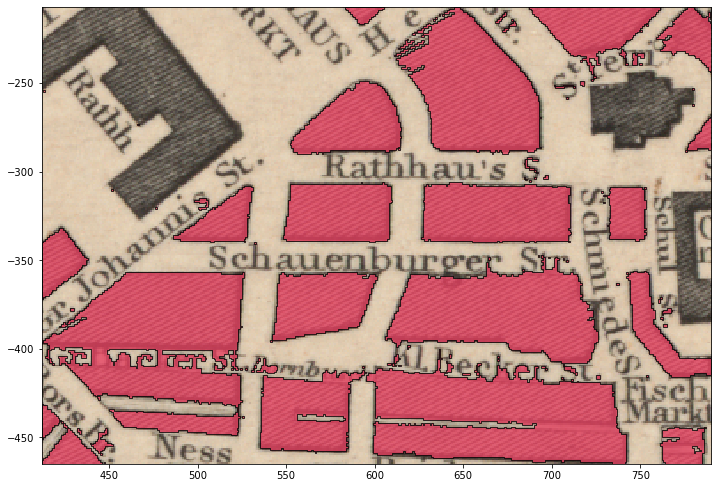

In [21]:
# plot vector on map
fig, ax = plt.subplots(figsize=(12, 10))
show(rgb_cropped.read(), transform=rgb_cropped.transform, ax=ax)
gdf.plot(ax=ax, color='#ec4062', edgecolor='black', linewidth=1, alpha=.75)
plt.show()

## 4.5) Remove small polygons
with the help of a simple area or perimeter threshold (see also Iosifescu et al. (2016))
### 4.5.1) calculate area/perimeter in QGIS and remove e.g. single pixels or polygons which are too small to represent a building<br>
<img src="figures/remove-small-polygons.PNG" width="400" align="left"/>

### 4.5.2) GeoPandas

In [23]:
# define threshold for small areas
threshold = 500

In [24]:
exploded = gdf.explode()
exploded["area"] = exploded['geometry'].area
exploded = exploded[exploded.area >= threshold]

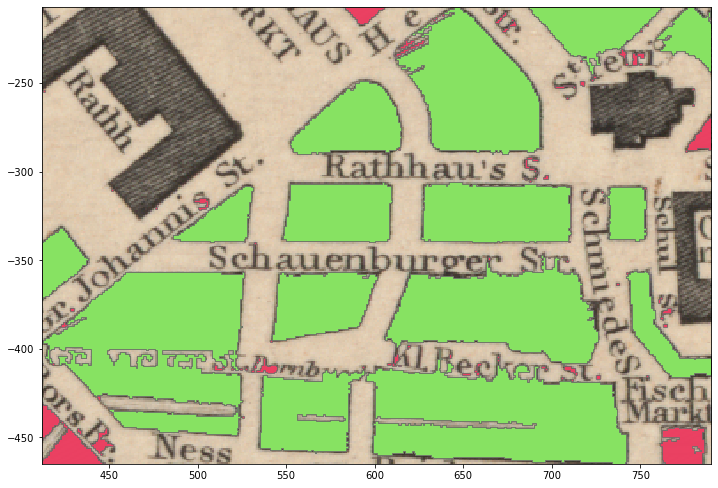

In [25]:
# plot vector on map
fig, ax = plt.subplots(figsize=(12, 10))
show(rgb_cropped.read(), transform=rgb_cropped.transform, ax=ax)
gdf.plot(ax=ax, color='#ec4062', edgecolor='dimgrey', linewidth=.7, alpha=.99)
exploded.plot(ax=ax, color='#86E563', edgecolor='dimgrey', linewidth=.7, alpha=.99)
plt.show()

## 4.6) Remove spikes
by buffering the data<br><br>
Iosifescu et al. (2016) measured the medium width of a spike and defined it as a buffer distance. They buffered the features and - afterwards - generated a negative buffer with the same distance inside the initial buffered data. By doing so, they were able to highlight the spikes for each feature.<br>
Own tests revealed that either the spikes still exist or the newly generated building edge were unsatisfactory:<br>
<img src="figures/remove-spikes-Iosifescu.png" width="150" align="left"/>

Therefore, we developed an own approach - similar to the one of Iosifescu et al. (2016): **first** negative and **afterwards** positive buffer:<br>
1) negative buffer around features (buffer distance: -2 pixels)<br>
2) positive buffer around negative buffer (buffer distance: 2 pixels)<br>
<img src="figures/remove-spikes-Iosifescu_otherwayround.png" width="150" align="left"/>

The buffer distance was defined manually via trial-and-error. Hence, this is a quite subjective measure...

In [27]:
# define buffer distance 
distance = 2

In [28]:
buffer_pos = exploded.geometry.buffer(distance*(-1), resolution=10, cap_style=1, join_style=2, mitre_limit=2)
buffer_neg = buffer_pos.geometry.buffer(distance, resolution=10, cap_style=1, join_style=2, mitre_limit=2)

In [29]:
# unify multipolygons and polygons within *buffer_neg* by converting Polygons into MultiPolygons.
# We have to do this so that we can plot the data
shapes=[]
for geom in buffer_neg:
    if type(geom) == shapely.geometry.polygon.Polygon:
        m = MultiPolygon([geom])
        shapes.append(m)
    if type(geom) == shapely.geometry.multipolygon.MultiPolygon:
        shapes.append(geom)
df_temp = pd.DataFrame(shapes)

# move values from multiple columns, which were generated by MultiPolygons, into a new single row
# so that we have one single 'geometry' column in order to build a (Geo)DataFrame from it
df_temp = df_temp.melt(id_vars=[0])
df_temp = df_temp.melt(id_vars=[0])

# drop unneccessary columns which were generated by pd.melt()
del df_temp['variable']
del df_temp['value']

# drop empty (None) geometries
df_buffer_neg = df_temp[df_temp[0].notnull()]

In [30]:
# convert DataFrame to GeoDataFrame so that we can plot it within the next step
df_buffer_neg = df_buffer_neg.reset_index()
df_buffer_neg.index=pd.to_numeric(df_buffer_neg.index)
df_buffer_neg = df_buffer_neg.rename(columns ={0:'geometry'})
buffer_neg = gpd.GeoDataFrame(df_buffer_neg, geometry='geometry')

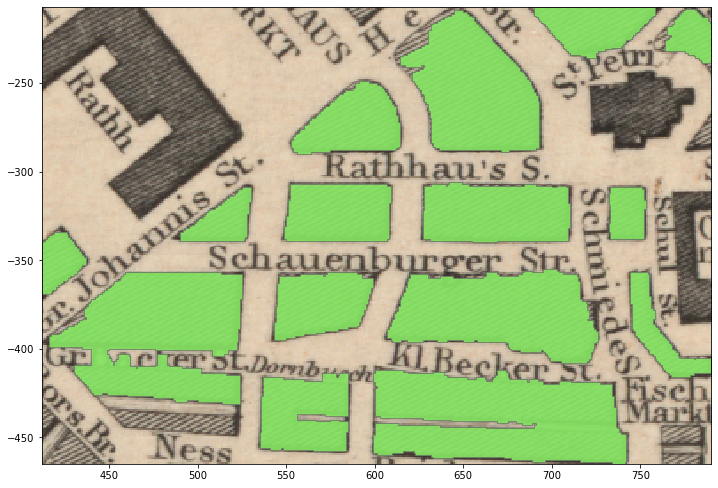

In [31]:
# plot vector on map
fig, ax = plt.subplots(figsize=(12, 10))
rgb_cropped = rasterio.open(featurefolder + posteditingfolder + tempfolder + "/subset_RGB_masked.tif", driver='GTiff') #RGB
show(rgb_cropped.read(), transform=rgb_cropped.transform, ax=ax)
buffer_neg.plot(ax=ax, color='#86E563', edgecolor='dimgrey', linewidth=.7, alpha=.7)
plt.show()

In [32]:
# export to file
if createsubset == 'yes':
    buffer_neg.to_file(featurefolder + posteditingfolder + "\\" + outputname + "_subset_buffered_minus2_buffered_plus2.shp")
else:
    buffer_neg.to_file(featurefolder + posteditingfolder + "\\" + outputname + "_buffered_minus2_buffered_plus2.shp")

## 4.7) Further tests: Straighten building edges
See Heitzler & Hurni, 2020, p. 451

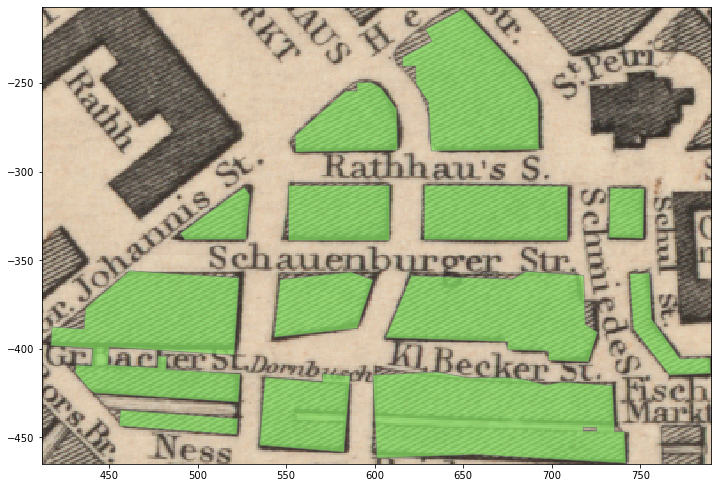

In [32]:
# import file which was exported from ETH's pipeline
buildings_positioned = gpd.read_file('buildings_positioned.shp')

# plot vector on map
fig, ax = plt.subplots(figsize=(12, 10))
show(rgb_cropped.read(), transform=rgb_cropped.transform, ax=ax)
buildings_positioned.plot(ax=ax, color='#86E563', edgecolor='dimgrey', linewidth=.7, alpha=.7)
plt.show()

**In our case, this tool did not show any improvements as our used input map has rounded and nonparallel edges.**

# 5) References
Arteaga, M. G. (2013). Historical map polygon and feature extractor. Proceedings of the 1st ACM SIGSPATIAL International Workshop on MapInteraction, 66-71. https://doi.org/10.1145/2534931.2534932<br><br>
Brown, K. D. (2002). Raster to Vector Conversion of Geologic Maps: Using R2V from Able Software Corporation. Digital Mapping Techniques ’02 – Workshop Proceedings. 203-205.<br><br>
Gede, M., Árvai, V., Vassányi, G., Supka, Z., Szabó, E., Bordács, A., Varga, C. G., & Irás, K. (2020). Automatic vectorisation of old maps using QGIS – tools, possibilities and challenges. In I. Krisztina (Ed.), Automatic Vectorisation of Historical Maps (pp. 37-43). Department of Cartography and Geoinformatics, ELTE Eötvös Loránd University.<br><br>
Godfrey, B., & Eveleth, H. (2015). An Adaptable Approach for Generating Vector Features from Scanned Historical Thematic Maps Using Image Enhancement and Remote Sensing Techniques in a Geographic Information System. Journal of Map and Geography Libraries, 11(1), 18-36. https://doi.org/10.1080/15420353.2014.1001107<br><br>
Heitzler, M., & Hurni, L. (2020). Cartographic reconstruction of building footprints from historical maps: A study on the Swiss Siegfried map. Transactions in GIS, 24(2), 442–461. https://doi.org/10.1111/tgis.12610<br><br>
Iosifescu, I., Tsorlini, A., & Hurni, L. (2016). Towards a comprehensive methodology for automatic vectorization of raster historical maps. e-Perimetron, 11(2), 57-76.<br><br>
Peller, P. (2018). From Paper Map to Geospatial Vector Layer: Demystifying the Process. IASSIST Quarterly, 42(3), 1-24. https://doi.org/10.29173/iq914